In [21]:
import csv
import collections
import copy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn.metrics as metrics

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Activation, Dense, Input, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, Precision, Recall

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from scipy.stats import uniform, randint

# Leitura dos registros de treinamento:

In [22]:
csv_path_training_gases = "Datasets/1.0-dataset/train_samples.csv"
with open(csv_path_training_gases, mode = 'r') as file:
    csv_reader_training_gases = csv.reader(file)
    next(csv_reader_training_gases)

    train_samples = []
    for row in csv_reader_training_gases:
        train_samples.append(row)
        
csv_path_training_faults = "Datasets/Duval-pentagon-labels/1.0_dataset_labels.csv"
with open(csv_path_training_faults, mode = 'r') as file:
    csv_reader_training_faults = csv.reader(file)
    next(csv_reader_training_faults)

    train_labels = []
    for row in csv_reader_training_faults:
        train_labels.append(row)

# Normalização dos treinos:

In [23]:
# normalização dos gases
train_samples = np.array(train_samples)
train_labels = np.array(train_labels)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_samples = scaler.fit_transform(train_samples)
scaled_train_samples = np.array(scaled_train_samples)

# normalização das falhas
train_labels = train_labels.flatten()
int_scaled_train_labels = (train_labels.astype(float)-1).astype(int)
int_scaled_train_labels = np.array(int_scaled_train_labels)

# Criação do modelo da Rede neural:

In [24]:
def create_functional_model():
    model = Sequential([
        Input(shape=(5,)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(7, activation='softmax')
    ]) 

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

functional_model = create_functional_model()
history = functional_model.fit(scaled_train_samples, int_scaled_train_labels, validation_split=0, epochs=3000, batch_size=25, verbose=2)

Epoch 1/3000
560/560 - 1s - loss: 1.4292 - accuracy: 0.4621 - 1s/epoch - 2ms/step
Epoch 2/3000
560/560 - 1s - loss: 1.1927 - accuracy: 0.5374 - 589ms/epoch - 1ms/step
Epoch 3/3000
560/560 - 1s - loss: 1.1442 - accuracy: 0.5444 - 595ms/epoch - 1ms/step
Epoch 4/3000
560/560 - 1s - loss: 1.1196 - accuracy: 0.5479 - 576ms/epoch - 1ms/step
Epoch 5/3000
560/560 - 1s - loss: 1.1039 - accuracy: 0.5594 - 584ms/epoch - 1ms/step
Epoch 6/3000
560/560 - 1s - loss: 1.0922 - accuracy: 0.5594 - 650ms/epoch - 1ms/step
Epoch 7/3000
560/560 - 1s - loss: 1.0718 - accuracy: 0.5637 - 624ms/epoch - 1ms/step
Epoch 8/3000
560/560 - 1s - loss: 1.0719 - accuracy: 0.5690 - 578ms/epoch - 1ms/step
Epoch 9/3000
560/560 - 1s - loss: 1.0586 - accuracy: 0.5765 - 619ms/epoch - 1ms/step
Epoch 10/3000
560/560 - 1s - loss: 1.0458 - accuracy: 0.5819 - 663ms/epoch - 1ms/step
Epoch 11/3000
560/560 - 1s - loss: 1.0313 - accuracy: 0.6000 - 581ms/epoch - 1ms/step
Epoch 12/3000
560/560 - 1s - loss: 1.0164 - accuracy: 0.6134 - 587

# Plotagem das métricas de treinamento:

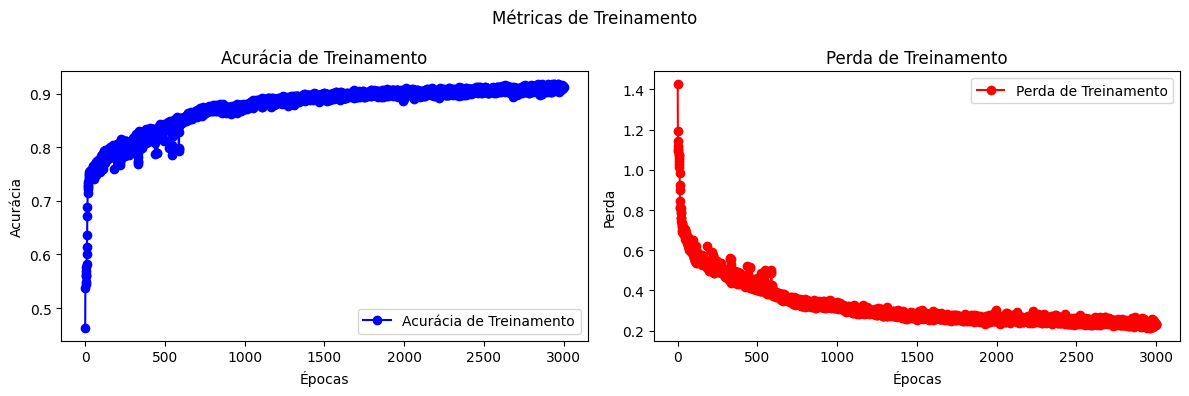

In [25]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Métricas de Treinamento')

    ax1.plot(epochs, acc, 'bo-', label='Acurácia de Treinamento')
    ax1.set_title('Acurácia de Treinamento')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Acurácia')
    ax1.legend()

    ax2.plot(epochs, loss, 'ro-', label='Perda de Treinamento')
    ax2.set_title('Perda de Treinamento')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Perda')
    ax2.legend()

    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        val_loss = history.history['val_loss']
        ax1.plot(epochs, val_acc, 'g-', label='Acurácia de Validação')
        ax2.plot(epochs, val_loss, 'm-', label='Perda de Validação')
        ax1.legend()
        ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Leitura dos registros de teste:


In [32]:
csv_path_testing_gases = "Datasets/840-test-dataset/test_samples.csv"
with open(csv_path_testing_gases, mode = 'r') as file:
    csv_reader_testing_gases = csv.reader(file)
    next(csv_reader_testing_gases)
    
    test_samples = []
    for row in csv_reader_testing_gases:
        test_samples.append(row)

csv_path_testing_faults = "Datasets/840-test-dataset/test_labels.csv"
with open(csv_path_testing_faults, mode = 'r') as file:
    csv_reader_testing_faults = csv.reader(file)
    next(csv_reader_testing_faults)
    
    test_labels = []
    for row in csv_reader_testing_faults:
        test_labels.append(row)

# Normalização dos testes:

In [33]:
# normalização dos gases de teste
test_samples = np.array(test_samples)
test_labels = np.array(test_labels)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_test_samples = scaler.fit_transform(test_samples)
scaled_test_samples = np.array(scaled_test_samples)

# normalização das falhas de teste
test_labels = test_labels.flatten()
int_scaled_test_labels = (test_labels.astype(float)-1).astype(int)
int_scaled_test_labels = np.array(int_scaled_test_labels)

# Teste e análise do modelo:

27/27 [==============================] - 0s 813us/step
Balanced Accuracy: 0.4452
Acurácia no conjunto de teste: 0.4452
Perda no conjunto de teste: 40.8117

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.21      0.32      0.26       120
           1       0.52      0.20      0.29       120
           2       0.55      0.53      0.54       120
           3       0.54      0.56      0.55       120
           4       0.38      0.33      0.36       120
           5       0.46      0.26      0.33       120
           6       0.54      0.92      0.68       120

    accuracy                           0.45       840
   macro avg       0.46      0.45      0.43       840
weighted avg       0.46      0.45      0.43       840



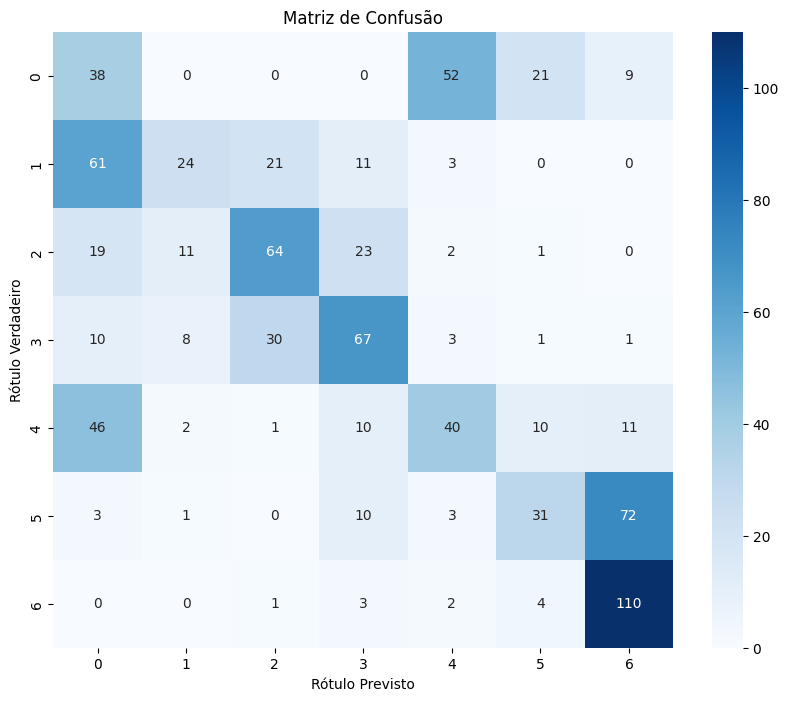

In [34]:

# realizando predições com o modelo treinado
y_pred = functional_model.predict(scaled_test_samples)
y_pred_classes = np.argmax(y_pred, axis=1)

# avaliando o modelo
test_loss, test_accuracy = functional_model.evaluate(scaled_test_samples, 
                                                   int_scaled_test_labels, 
                                                   verbose=0)
balanced_acc = balanced_accuracy_score(int_scaled_test_labels, y_pred_classes)
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")
print(f"Perda no conjunto de teste: {test_loss:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(int_scaled_test_labels, y_pred_classes, zero_division=0))

# matriz de confusão
cm = confusion_matrix(int_scaled_test_labels, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()
